In [2]:
import os
import re

from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Input and output filepaths
train_clean_100_path = os.path.join("data", "train-clean-100.csv")
dev_clean_path = os.path.join("data", "dev-clean.csv")
test_clean_path = os.path.join("data", "test-clean.csv")

os.makedirs("data", exist_ok=True)

In [4]:
# helper functions to normalize the words in the books
# Used to remove short words. how short is a short words
_short = 0

# Used to remove stopwords from the english language
_more_stopwords = set([
    # interjections
    "oh", "ah",
    # useless
    "yes", "no",
    # archaic terms: they, you, triplet, to do, you
    "thy", "thou", "thrin", "didst", "thee"
])
_stopwords = set(stopwords.words('english')) | _more_stopwords

# Used to lemmatize words that are either adj, nouns or verbs
# depending on _pos_tags otherwise it does nothing.
_lemmatizer = WordNetLemmatizer()
_pos_tags = ["a", "n", "v"]

# Used for min/max filering. CountVectorizer removes words 
# that have a frequency higher that max_df. It also removes 
# words that appear in less documents than min_df.
_max_df = 0.30
_min_df = 5

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
# Used to decontract words that contain "'".
def decontract(phrase: str):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def is_not_short(word):
    return len(word) > _short

def not_in_stopwords(word):
    return word not in _stopwords

def lemmatize(pair):
    word, pos = pair
    pos = pos[0].lower()
    if pos not in _pos_tags:
        return word
    return _lemmatizer.lemmatize(word, pos=pos)

def document_analyzer(book: str):
    book = str.lower(book)
    book = decontract(book)
    words = word_tokenize(book)
    words = list(filter(is_not_short, words))
    words = list(filter(not_in_stopwords, words))
    words = list(map(lemmatize, pos_tag(words)))
    return words

In [5]:
train_df = pd.read_csv(train_clean_100_path, index_col=0)
dev_df = pd.read_csv(dev_clean_path, index_col=0)
test_df = pd.read_csv(test_clean_path, index_col=0)

train_df =  pd.DataFrame({"TEXT": train_df["REAL TEXT"].apply(document_analyzer), "BOOK": train_df["BOOK TITLE"]})
dev_df = pd.DataFrame({"TEXT": dev_df["TEXT"].apply(document_analyzer), "BOOK": dev_df["BOOK TITLE"]})
test_df = pd.DataFrame({"TEXT": test_df["TEXT"].apply(document_analyzer), "BOOK": test_df["BOOK TITLE"]})

train_df

In [ ]:
word2vec = Word2Vec(sentences=[*train_df["TEXT"].to_list(), *dev_df["TEXT"].to_list()], seed=42)
X = np.array([np.mean([word2vec.wv[w] for w in text if w in word2vec.wv] or [np.zeros(100)], axis=0) for text in test_df["TEXT"].to_list()])

In [ ]:
n_clusters = 15

km = KMeans(n_clusters=n_clusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=42)
y_hat = km.fit_predict(X)

In [ ]:
tnse = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_features = tnse.fit_transform(X)
tsne_df = pd.DataFrame(tsne_features)
tsne_df['TOPIC'] = y_hat
tsne_df['BOOK'] = test_df['BOOK']

tsne_df.columns = ['TSNE1', 'TSNE2', 'TOPIC', 'BOOK']

[t-SNE] Computing 53 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.777140
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.168690
[t-SNE] KL divergence after 950 iterations: 0.004312


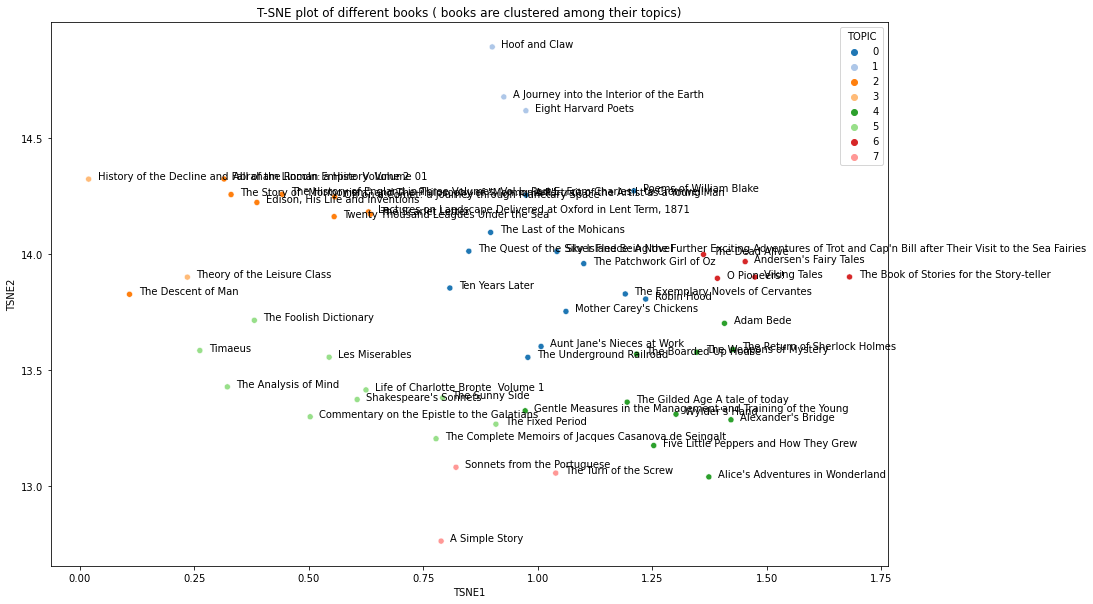

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('T-SNE plot of different books ( books are clustered among their topics)')
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='TOPIC', data=tsne_df, legend='full', palette="tab20")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['BOOK'], plt.gca())

plt.show()

In [ ]:
def get_top_n_words(books, n=10):
    words_freq = sum(map(Counter, books), start=Counter()).items()
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words_freq = list(map(lambda p: p[0], words_freq))
    return words_freq[:n]

def print_topics(words_freq, topic):
    print("Topic %d:" % (topic), end='')
    print(words_freq)

df = test_df.copy(deep=True)
df['TOPIC'] = y_hat

for i in range(n_clusters):
    books = df[df['TOPIC'] == i]['TEXT'].to_list()
    print_topics(get_top_n_words(books, 15), topic=i)

Topic 0:
[('say', 68), ('one', 63), ('upon', 38), ('would', 37), ('like', 36), ('give', 35), ('make', 33), ('come', 30), ('know', 28), ('take', 28), ('much', 26), ('see', 26), ('think', 25), ('go', 23), ('little', 23)]
Topic 1:
[('upon', 11), ('head', 9), ('hawk', 9), ('sail', 7), ('seem', 7), ('raft', 7), ('eye', 7), ('light', 7), ('black', 6), ('wave', 6), ('sea', 6), ('white', 6), ('air', 6), ('come', 5), ('cloud', 5)]
Topic 2:
[('one', 31), ('would', 27), ('state', 21), ('could', 20), ('two', 20), ('day', 18), ('first', 18), ('time', 17), ('edison', 17), ('even', 16), ('upon', 16), ('men', 15), ('many', 15), ('little', 15), ('make', 14)]
Topic 3:
[('consumption', 13), ('class', 9), ('leisure', 8), ('may', 8), ('le', 7), ('consumer', 7), ('many', 6), ('also', 6), ('use', 6), ('good', 6), ('pecuniary', 6), ('waste', 6), ('comfort', 5), ('therefore', 5), ('life', 5)]
Topic 4:
[('say', 65), ('know', 45), ('like', 39), ('would', 36), ('go', 35), ('make', 32), ('come', 32), ('one', 31), 